# Single-photon Simulation
- The following notebook demonstrates the use of the emulator to simulate the propagation of a single photon in a quantum photonic processor.
- This can be used to find the unitary implemented by a system.
- First import required modules and some additional tools.

In [1]:
import lightworks as lw
from lightworks import emulator, State

from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from collections import Counter

- A general N is then defined, which is used to adjust the number of modes used for the circuit throughout the notebook.

In [2]:
N = 8

- Can then create a random unitary matrix which is programmed onto the chip.

In [3]:
U = lw.random_unitary(N)

circuit = lw.Unitary(U)

## Simulator
- First we try using the simulation part of the emulator. This allows the simulation of a number of input states, finding the probability amplitudes for the given outputs.
- To set this up, we specify the generated circuit to the simulator class. 

In [4]:
sim = emulator.Simulator(circuit)

- In this case we will choose to try to recreate the unitary matrix, which can be done by creating a list of all single photon input and output states.

In [5]:
states = []

# Create all single photon states by adding 1 to list when i=j, otherwise add 0
for i in range(N):
    state = []
    for j in range(N):
        if i == j:
            state += [1]
        else:
            state += [0]
    states.append(State(state))

# Calculate probability amplitude
results = sim.simulate(states, states)
U_calc = results.array

- The resultant matrix probability amplitude matrix can be visualized below, and we see that the unitary is correctly replicated.
- Note that the unitary needs to be transposed for the plotting below to show identical matrices.

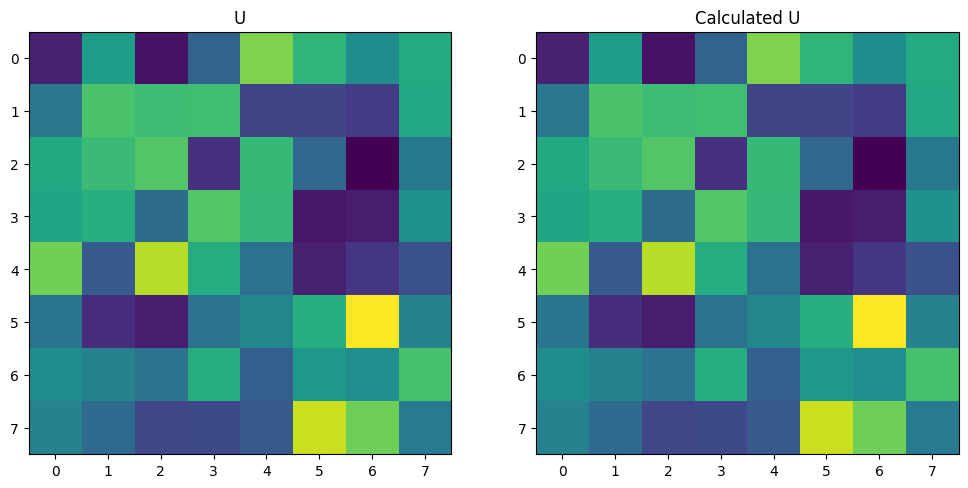

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].imshow(abs(U.T))
ax[1].imshow(abs(U_calc))
ax[0].set_title("U")
ax[1].set_title("Calculated U")

plt.show()

- It is also possible to directly view the probability amplitudes in a nicer form using the display_as_dataframe function included with the results object. 
- In this case the values are converted to probabilities with the conv_to_probability keyword.

In [7]:
results.display_as_dataframe(conv_to_probability = True)

,"|1,0,0,0,0,0,0,0>","|0,1,0,0,0,0,0,0>","|0,0,1,0,0,0,0,0>","|0,0,0,1,0,0,0,0>","|0,0,0,0,1,0,0,0>","|0,0,0,0,0,1,0,0>","|0,0,0,0,0,0,1,0>","|0,0,0,0,0,0,0,1>"
"|1,0,0,0,0,0,0,0>",0.007163,0.149016,0.003434,0.054392,0.296432,0.199166,0.114965,0.175432
"|0,1,0,0,0,0,0,0>",0.080720,0.236196,0.219294,0.222318,0.024637,0.025542,0.019866,0.171426
"|0,0,1,0,0,0,0,0>",0.174588,0.216304,0.246639,0.013733,0.208121,0.057472,0.000698,0.082446
"|0,0,0,1,0,0,0,0>",0.164592,0.183281,0.063770,0.248064,0.205632,0.004504,0.005918,0.124238
"|0,0,0,0,1,0,0,0>",0.283656,0.044348,0.361005,0.180278,0.072396,0.007359,0.016519,0.034438
"|0,0,0,0,0,1,0,0>",0.076580,0.011676,0.006031,0.070231,0.103234,0.187141,0.447557,0.097551
"|0,0,0,0,0,0,1,0>",0.115712,0.096055,0.073553,0.183041,0.047434,0.137020,0.115854,0.231331
"|0,0,0,0,0,0,0,1>",0.096989,0.063124,0.026273,0.027944,0.042114,0.381796,0.278622,0.083138


## Sampler
- The other way to use the emulator is as a sampler.
- This is achieved using the Sampler class, to which we provide the generated circuit and single input state that we want to look at. In this case we input a single photon on mode 0.

In [8]:
sampler = emulator.Sampler(circuit, State([1]+[0]*(N-1)))

- Once the sampler has been set up, we can then sample from it many times.
- The probability distribution was pre-calculated in the last step, so the sampling procedure takes place very quickly.
- We get the output state from the sample, and convert this into a mode number which is stored.

In [9]:
N_rep = 100 # Set number of samples
results = []

for i in range(N_rep):
    state = sampler.sample()
    # Get state from sampler and find which more the photon is on
    loc = state.s.index(1)
    results.append(loc)

# Count number of times we measure a photon on each mode
counted = Counter(results)

- The counts can then be converted into probabilities and compared to the expected values from the unitary.
- As we only choose to look at 100 samples here, the measured and expected distributions tend to vary as not enough samples have been taken to see convergence.

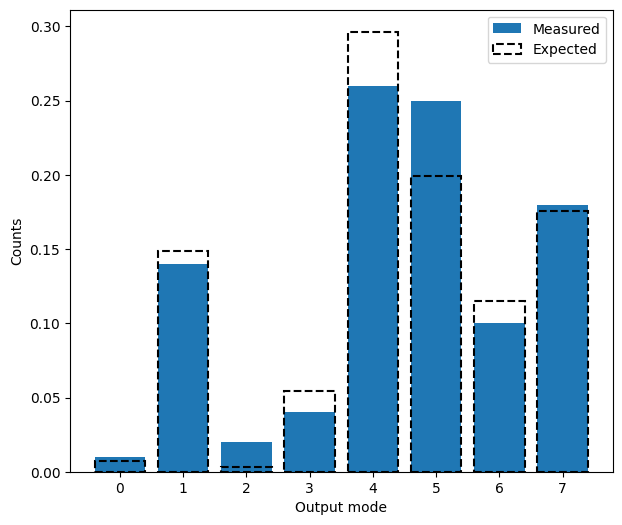

In [10]:
x = range(N)

# Convert counts to a list and normalise to total count numbers
p_calc = []
for i in x:
    p_calc.append(counted[i]/sum(counted.values()))

# Find expected distribution
p_exp = abs(U.T[0,:])**2

plt.figure(figsize = (7,6))
plt.bar(x, p_calc, label = "Measured", alpha = 1)
plt.bar(x, p_exp, label = "Expected", edgecolor = "Black", fill = False,
        linestyle = "dashed", linewidth = 1.5)
plt.xlabel("Output mode")
plt.ylabel("Counts")
plt.legend()
plt.show()